# Kalman Filter

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la
from scipy.stats import multivariate_normal as mvn

plt.style.use("seaborn-v0_8")

In [2]:
# Parameters for 1D motion dynamics
dt = 1.0
R_var = 1
Q_var = 0.1

x_init = [0.0, 15.0]
x = np.array(x_init).reshape(2, 1)
A = np.array([[1.0, dt], [0, 1.0]])
C = np.array([[1.0, 0]])
P = np.diag([0.5, 0.1])  # covariance matrix for the state estimate
Q = np.diag([Q_var, Q_var])  # covariance matrix for the process disturbance
R = np.array([[R_var]])  # covariance matrix for the measurement noise

In [3]:
P

array([[0.5, 0. ],
       [0. , 0.1]])

In [4]:
# Generate the ground truth 1D motion and noisy measurements
num_iter = 100


def generate_1d_motion(x: np.ndarray, A: np.ndarray, count) -> tuple[np.ndarray, np.ndarray]:
    xs = [x]
    for i in range(count):
        x = A @ x
        xs.append(x)

    return np.array(xs)


def generate_1d_measurement(
    x: np.ndarray, C: np.ndarray, R: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    ys = []
    for i in range(x.shape[0]):
        y = C @ x[i, :]
        r, c = y.shape
        y += mvn.rvs(mean=np.zeros(r), cov=R, size=1)
        ys.append(
            y.reshape(
                r,
            )
        )

    return np.array(ys)


xs = generate_1d_motion(x, A, num_iter)
ys = generate_1d_measurement(xs, C, R)


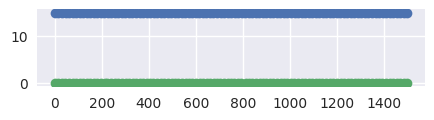

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.plot(xs[:, 0], xs[:, 1], 'o-')
ax.plot(ys, np.zeros_like(ys), 'o-')
plt.show()

## Prediction only

In [6]:
# Prediction only
N = 100

x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)

x_pred = np.zeros((num_iter + 1, N, 2))
x_pred[0, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

for i in range(num_iter):
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    x_pred[i + 1, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

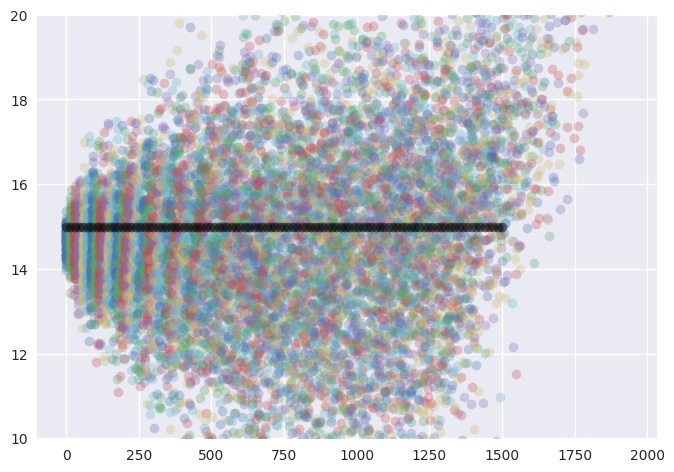

In [7]:
fig, ax = plt.subplots()

for z in range(num_iter + 1):
    ax.plot(x_pred[z, :, 0], x_pred[z, :, 1], 'o', alpha=0.3)

ax.plot(xs[:, 0], xs[:, 1], 'o', color='k', alpha=0.5)
ax.set_ylim(10, 20)

plt.show()

## Prediction and measurement update

In [8]:
# Define a number of iterations and an array to store the state estimates
N = 100
x_meas = np.zeros((num_iter + 1, N, 2))

# Initial noisy estimate and measurement∏
x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)


def kalman_gain(P: np.ndarray, C: np.ndarray, R: np.ndarray) -> np.ndarray:
    """Calculate the Kalman gain."""
    S = C @ P @ C.T + R
    K = P @ C.T @ la.inv(S)
    return K


K = kalman_gain(P, C, R)
x_hat = x_hat + K @ (ys[0] - C @ x_hat)
P = P - K @ C @ P

x_meas[0, :, :] = mvn.rvs(
    mean=x_hat.reshape(
        2,
    ),
    cov=P,
    size=N,
)

print(x_hat)
# [[ 0.46355285]
#  [15.3781233 ]]

[[ 1.04170829]
 [13.0765879 ]]


In [9]:
# Iterative prediction and measurement update
for i in range(num_iter):
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    # measurement update
    if i % 20 == 0:
        K = kalman_gain(P, C, R)
        x_hat = x_hat + K @ (ys[i + 1] - C @ x_hat)
        P = P - K @ C @ P

    x_meas[i + 1, :, :] = mvn.rvs(
        mean=x_hat.reshape(
            2,
        ),
        cov=P,
        size=N,
    )

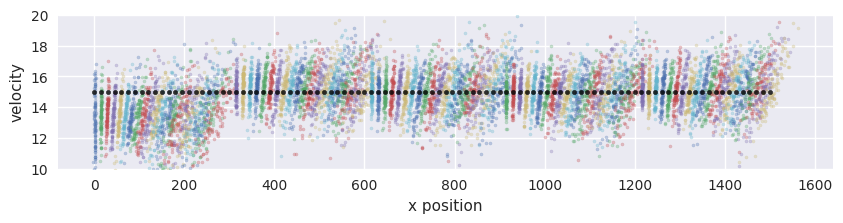

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

for i in range(num_iter + 1):
    # Scatter plot
    ax.scatter(x_meas[i, :, 0], x_meas[i, :, 1], s=5, alpha=0.3)

# Plot the ground truth
ax.scatter(xs[:, 0], xs[:, 1], s=10, color="k", alpha=0.8)
ax.set_ylim(10, 20)
ax.set_xlabel("x position")
ax.set_ylabel("velocity")

plt.show()

In [47]:
x_meas[i, :, 0]

array([1499.50463166, 1500.36673287, 1499.4481075 , 1500.3238251 ,
       1500.4942706 , 1500.67846794, 1500.67426669, 1499.26191393,
       1500.70558498, 1499.30577581, 1499.71000509, 1499.71715855,
       1500.5336257 , 1499.27582582, 1499.81745961, 1500.93649118,
       1499.23054709, 1499.34698754, 1500.47843911, 1500.26872409,
       1499.74853953, 1499.65756722, 1499.44429554, 1499.00702312,
       1501.35540912, 1500.28034681, 1499.58533723, 1500.93318487,
       1500.47758999, 1501.8021243 , 1500.1412268 , 1499.65341906,
       1500.80310633, 1500.63400957, 1498.83838994, 1500.0373907 ,
       1499.96436788, 1500.16356087, 1499.10877044, 1500.79780185,
       1501.77705869, 1500.89853868, 1500.57425205, 1500.54925417,
       1498.41808498, 1499.32569675, 1500.7577454 , 1500.07257516,
       1500.19256464, 1500.09136383, 1500.73998524, 1501.09484284,
       1501.05834146, 1500.21021845, 1500.74503766, 1500.58904955,
       1499.47252667, 1498.60983781, 1501.66124118, 1500.85945